## Importing libraries

In [79]:
import pandas as pd
import gzip
import csv
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import dateutil
from IPython.core.display import display, HTML
import os

import pylab

from IPython.display import display
from scipy import optimize

import time
#from colorama import init 
#from termcolor import colored

## Read CSV file

In [80]:
df = pd.read_csv('example_dataset.csv',sep=',\s+', delimiter=',', encoding="utf-8", skipinitialspace=True)

In [81]:
# show all headers
df.columns

Index(['nm_bedrooms', 'ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooking_range', 'cool_stpnt', 'cool_stpnt_ofst_mag',
       'cool_stpnt_ofst_prd', 'dish_washer', 'ducts', 'nm_floors',
       'foundation', 'garage', 'house_size', 'heating_fuel', 'heat_stpnt',
       'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
       'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
       'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration',
       'insulation_crawlspace', 'insulation_finished_basement',
       'insulation_finished_roof', 'insulation_interzonal_floor',
       'insulation_slab', 'insulation_unfinished_attic',
       'insulation_unfinished_basement', 'insulation_wall', 'lighting',
       'location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
       'pool', 'well_pump', 'neighbors', 'orientation', 'plug_loads',
       'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
       'wat

## Select specific variables from data set

In [82]:
#clothes_washer

df = df[[ 'nm_bedrooms', 'ceiling_fan', 'clothes_dryer', #'clothes_washer',
         'cool_stpnt', 'cool_stpnt_ofst_mag', #'cooking_range', 
         'ducts','nm_floors',#'cool_stpnt_ofst_prd','dish_washer',
         ##'garage', ##'heat_stpnt',#'foundation','house_size','heating_fuel',
         #'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
         #'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
         #'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration', 
         #'lighting','location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
         #'pool','well_pump', 'neighbors',
         #'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
         #'water_heater', 'windows',
         'total_site_energy' ]]


df.head(5)

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292


## Method to update distriubtion based on new mean and variance

In [83]:

def newWeightOptimization(oldWeights,vals,newMean,numberOfMoments):
    #recommended Number of moments = len(oldWeights)
    numberOfMoments = len(oldWeights)
    oldMean = 0
    for i in range(len(oldWeights)):
        oldMean += oldWeights[i]*vals[i]
    
    #calculate moments:
    moments = np.zeros(numberOfMoments)
    for i in range(numberOfMoments):
        for j in range(len(oldWeights)):
            moments[i]+=oldWeights[j]*((vals[j]-oldMean)**(i+2))
    
    bounds = []
    for i in range(len(oldWeights)):
        bounds.append((0,1))
    bounds = tuple(bounds)
    
    constraints = [{'type':'eq', 'fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x: np.dot(x,vals)-newMean}]
    
    def _func(x):
        
        Xmatrix = np.zeros((numberOfMoments,len(oldWeights)))

        for i in range(numberOfMoments):
            for j in range(len(oldWeights)):
                Xmatrix[i,j] = (vals[j]-newMean)**(i+2)
                
        Xmatrix /= np.linalg.norm(Xmatrix)
        #Xmatrix*=100
        objective = 0
        for i in range(numberOfMoments):
            objective += ((.5)*i)*(Xmatrix[i,:].dot(x))**2
        
        #optional regularization:
        
#         for i in range(len(x)):
#             objective += newMean*x[i]*np.log(x[i])
            
        return objective
    x0 = np.random.rand(len(oldWeights))
    x0/=sum(x0)
    res = optimize.minimize(_func,x0,bounds=bounds,constraints=constraints)
    
    return res.x
                


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


## 1- Adding sample distribution columns to dataset

In [84]:
%%time

# get lenght of dataframe
N = float(len(df))

# get distributions 
for c in df.columns:  
        if c == 'total_site_energy' or c == 'weight':
            continue
        print(f"Processing {c}")
        counts = df[c].value_counts()
        
        # find distributions and add distribution columns to dataframe
        df[c+'_dist'] = df[c].map(lambda x: counts.loc[x]) / N


Processing nm_bedrooms
Processing ceiling_fan
Processing clothes_dryer
Processing cool_stpnt
Processing cool_stpnt_ofst_mag
Processing ducts
Processing nm_floors
Wall time: 4 s


In [85]:
# resulting dataframe
df.head()

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,ceiling_fan_dist,clothes_dryer_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,ducts_dist,nm_floors_dist
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018,0.618445,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635,0.255266,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763,0.618445,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627


# 2- Adding target distributions to data set

In [86]:
# decide what variable you want to change ( ex. set a new target distribution for number of bedrooms)
# find what is the mean of this variable and what would be your target mean
df.nm_bedrooms.mean()

2.3933198202167976

In [87]:
%%time
# generate target distributions
for c in df.columns:  
    
        if '_dist' not in c and '_target' not in c and 'site_energy' not in c and 'weight' not in c:
            
            print(f"*************Processing {c}**************")
            # zip variables and distributions
            z = dict(zip(df[c],df[c+'_dist']))
            print (f"old_dist = {z}")

            ### set inputs to weightConverion method
            #set vals
            vals = np.array(list(z.keys()))
            #set oldDist
            oldDist = np.array(list(z.values()))
            #set targeted means of each variable distribution that is going to change
            if c == 'nm_bedrooms':
                newMean = 3
            #for non changing variables the target distribution will be same as the original distribution
            else: 
                print (f"new_dist = {z}")
                df[c+'_target'] = df[c+'_dist']
                continue
                
            numberOfMoments = 3

            # find target distributions(weights) for each variable that have a new target mean
            w = newWeightOptimization(oldDist,vals,newMean,numberOfMoments)
            # output new distributions as a list
            w = w.tolist()
            
            #zip weight and values
            new_dist = dict(zip(vals,w))
            print(f"new_dist = {new_dist}")

            # layout target distribution in data frame
            y=[]
            for x in df[c]:
                y.append(new_dist[x])

            df[c+'_target'] = y

*************Processing nm_bedrooms**************
old_dist = {2.0: 0.6184454040715608, 3.0: 0.255265708997973, 1.0: 0.04498986516259804, 5.0: 0.012646514497223937, 4.0: 0.0651714109456244, 6.0: 0.0026438706265973387, 7.0: 0.0008372256984224906}
new_dist = {2.0: 0.2831584920905145, 3.0: 0.26483363006774396, 1.0: 0.1173230658102858, 5.0: 0.18311981167963104, 4.0: 0.15156500035182452, 6.0: 8.673617379884035e-19, 7.0: 1.4230153513872246e-19}
*************Processing ceiling_fan**************
old_dist = {'1 Fan, 120% Usage': 0.05071825152022561, '1 Fan, 100% Usage': 0.10121618048823477, '2 Fans, 120% Usage': 0.03181457654005464, '1 Fan, 80% Usage': 0.051070767603771924, '3 Fans, 120% Usage': 0.04446109103727858, 'None': 0.49167180752621836, '3 Fans, 80% Usage': 0.04472547809993831, '2 Fans, 80% Usage': 0.032078963602714373, '2 Fans, 100% Usage': 0.06358508856966599, '3 Fans, 100% Usage': 0.08865779501189741}
new_dist = {'1 Fan, 120% Usage': 0.05071825152022561, '1 Fan, 100% Usage': 0.1012161

In [88]:
#resulting dataframe
pd.set_option('display.max_columns', 100)
df.head()

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,ceiling_fan_dist,clothes_dryer_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,ceiling_fan_target,clothes_dryer_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,ducts_target,nm_floors_target
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018,0.618445,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351,0.283158,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635,0.255266,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351,0.264834,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763,0.618445,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351,0.283158,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351,0.264834,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627,0.264834,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627


## 3- Applying weighting method

In [89]:
df["weight"] = 1
#initial dataframe
df.head()

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,ceiling_fan_dist,clothes_dryer_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,ceiling_fan_target,clothes_dryer_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,ducts_target,nm_floors_target,weight
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018,0.618445,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351,0.283158,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351,1
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635,0.255266,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351,0.264834,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351,1
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763,0.618445,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351,0.283158,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351,1
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351,0.264834,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351,1
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627,0.264834,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627,1


## running weighting method

NORM DELTA_W = 
0.010936560493940007,0.0037120751242815547,0.002813729153658653,0.002051706109664434,0.0019636459475403595,0.001772903004661475,0.0017106072815265918,0.001584294156066911,0.0015274605173903105,0.0014232340971989596,0.0013705275073720095,0.0012806061718642482,0.0012315265997848083,0.0011529355902800225,0.001107309849124427,0.0010382375708643064,0.00099595895678526,0.0009350489351532942,0.0008959995487423991,0.0008421549849732303,0.0008061942574221081,0.0007585005553029052,0.0007254698107704262,0.0006831526830492652,0.0006528818949907243,0.0006152798103400219,0.000587593479543478,0.0005541375724646076,0.0005288593070210578,0.0004990579234559419,0.00047601386407300505,0.000449440307575169,0.0004284616178520694,0.00040474424542176295,0.0003856688633292216,0.0003644829721917532,0.00034715678311776177,0.0003282178967766114,0.00031249545695155454,0.0002955537238654826,0.00028129863746499765,0.00026613412618393153,0.0002532191589235058,0.0002396378831107725,0.000227944878595342

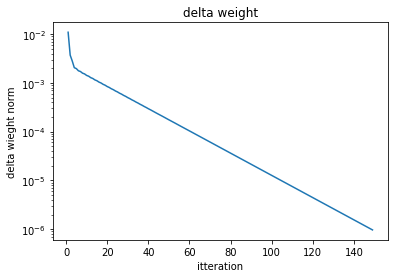

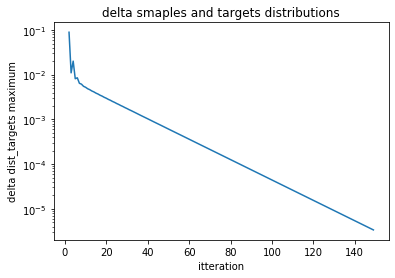

maximum of delta sample_target distributions = 3.3612082144252042e-06
mean of delta sample_target distributions = 3.102208502014116e-06
Wall time: 23.1 s


In [90]:

%%time

# initialize number of itterations
count = 0
itterations = []
# initialize delta_w list 
delta_w_list = []

# initialize delta_dist_vs_target
delta_dist_target = []

# check how the algorithm is progressing by traching delta weight
print("NORM DELTA_W = ")

# Set Solving tolerance(a lower tolerance will take more run time but disttribution will get closer to the target)
tol = 1e-6

# Initialize delta weight
delta_w_norm = 1.0/tol

# add Weight column to data frame (note that this weight column is for the whole dataframe and not for each column)
# all the Weights are intialized to be 1 as a start
df["weight"] = 1 

# while the delta weigth norm is less than the tolerance
while delta_w_norm > tol:

    #get total weight
    tW = df.weight.sum()
    
    # get w_old
    w_old = df['weight'].copy()
    
    # add number of itterations to a list
    count += 1
    itterations.append(count)  
    
    # change original distributions
    # distribution = weight for a corresponing categroy of a variable / tW 
    for c in df.columns:

        if 'total_site_energy' not in c and 'weight' not in c and '_dist' not in c and '_target' not in c and '_weight' not in c:

            #print (f"********processing {c}***********")   
            a = df[[c , 'weight']].groupby(c, as_index = False ).sum()
            dict_a = dict(zip(a[c], a['weight']))          
            df[c+'_dist'] = df[c].map(lambda x: dict_a[x]/tW)
            
            #get delta delta_dist_target
            # add number of itterations to a list
            delta_d_t = np.abs(df[c+'_target'] - df[c+'_dist'])
            
    
    # apply reweighting
    for c in df.columns:
        
        if 'total_site_energy' not in c and 'weight' not in c and '_dist' not in c and '_target' not in c and '_weight' not in c:
            # find weights for each variable
            # new weight = target distribution / sample distribution
            # update the main weight column by multiplying it with the new weights
            df['weight'] = (df[c+'_target'] / (df[c+'_dist']+1e-14)) * df['weight']
    
    
    
    # find new weight of output; w_new
    w_new = df['weight'].copy()

    # find delta weight
    delta_w = np.abs(w_new - w_old)
    # get delta weight norm
    delta_w_norm = np.sqrt(np.sum(np.power(delta_w,2.0)))/float(len(delta_w))
    # put delta_w in a list 
    delta_w_list.append(delta_w_norm)
    
    #print delta w norm
    print(f"{delta_w_norm},", end='')
    time.sleep(0.01)
    
    #get maximum delta_dist_target
    delta_d_t_max = delta_d_t.max()
    #put delta_dist_target in a list
    delta_dist_target.append(delta_d_t_max)

#### visualize results
fig,ax = plt.subplots()
fig,ax1 = plt.subplots()

# delta weight plot
ax.plot(itterations, delta_w_list)
ax.set_title('delta weight')
ax.set_ylabel('delta wieght norm')
ax.set_xlabel('itteration')
ax.set_yscale('log')

# delta smaple and target distributions
ax1.plot(itterations[1:], delta_dist_target[1:])
ax1.set_title('delta smaples and targets distributions')
ax1.set_ylabel('delta dist_targets maximum')
ax1.set_xlabel('itteration')
ax1.set_yscale('log')

plt.show()

#print info
print (f"maximum of delta sample_target distributions = {delta_d_t.max()}")
print (f"mean of delta sample_target distributions = {delta_d_t.mean()}")


In [91]:
# resulting data frame
df.head()

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,ceiling_fan_dist,clothes_dryer_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,ceiling_fan_target,clothes_dryer_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,ducts_target,nm_floors_target,weight
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018,0.283161,0.050718,0.184453,0.091214,0.278091,0.171500,0.696355,0.283158,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351,0.650723
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635,0.264834,0.101217,0.368160,0.091214,0.278091,0.309950,0.696355,0.264834,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351,1.493716
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763,0.283161,0.031814,0.184453,0.565248,0.424068,0.309950,0.696355,0.283158,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351,0.477516
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531,0.264834,0.051071,0.081960,0.565248,0.424068,0.076055,0.696355,0.264834,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351,1.211680
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292,0.264834,0.044461,0.184453,0.565248,0.424068,0.132237,0.272624,0.264834,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627,0.777426


In [27]:
print(df['nm_bedrooms_dist'].head(5))
print(df['nm_bedrooms_target'].head(5))
#print(w_old[:5])
#print(w_new[:5])

0    0.236976
1    0.190684
2    0.236976
3    0.190684
4    0.190684
Name: nm_bedrooms_dist, dtype: float64
0    0.236974
1    0.190684
2    0.236974
3    0.190684
4    0.190684
Name: nm_bedrooms_target, dtype: float64


In [28]:
df.head()

,nm_bedrooms,ceiling_fan,clothes_dryer,cool_stpnt,cool_stpnt_ofst_mag,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,ceiling_fan_dist,clothes_dryer_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,ceiling_fan_target,clothes_dryer_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,ducts_target,nm_floors_target,weight
0,2.0,"1 Fan, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,"10% Leakage, R-4",1.0,48.623018,0.236976,0.050718,0.184453,0.091214,0.278091,0.171500,0.696355,0.236974,0.050718,0.184454,0.091214,0.278091,0.171499,0.696351,0.593309
1,3.0,"1 Fan, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,"20% Leakage, R-4",1.0,38.585635,0.190684,0.101217,0.368160,0.091214,0.278091,0.309950,0.696355,0.190684,0.101216,0.368159,0.091214,0.278091,0.309950,0.696351,1.158656
2,2.0,"2 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, R-4",1.0,29.628763,0.236976,0.031814,0.184453,0.565250,0.424069,0.309950,0.696355,0.236974,0.031815,0.184454,0.565260,0.424077,0.309950,0.696351,0.411824
3,3.0,"1 Fan, 80% Usage",None,72F Variable Schedule,13F,"30% Leakage, Uninsulated",1.0,35.808531,0.190684,0.051071,0.081960,0.565250,0.424069,0.076055,0.696355,0.190684,0.051071,0.081960,0.565260,0.424077,0.076055,0.696351,0.910805
4,3.0,"3 Fans, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"20% Leakage, Uninsulated",2.0,70.214292,0.190684,0.044461,0.184453,0.565250,0.424069,0.132237,0.272625,0.190684,0.044461,0.184454,0.565260,0.424077,0.132238,0.272627,0.554841


# Visualize results

In [29]:
#len(itterations)

In [30]:
#len(delta_w_list)

In [539]:
#del itterations[-1]

In [540]:
#len(itterations)

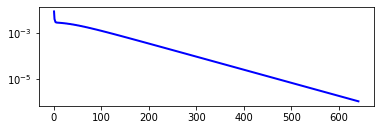

In [685]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.plot(itterations, delta_w_list, color='blue', lw=2)

ax.set_yscale('log')

pylab.show()

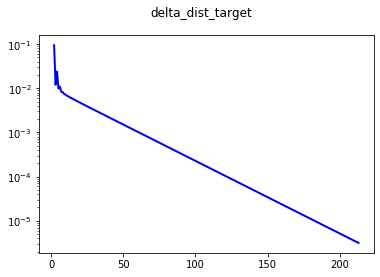

In [47]:
fig = plt.figure()
fig.suptitle('delta_dist_target')

#fig, ax_lst = plt.subplots(2,2)
ax = fig.add_subplot()

ax.plot(itterations[1:], delta_dist_target[1:], color='blue', lw=2)

ax.set_yscale('log')

pylab.show()

In [495]:
print(delta_w_list)
print(itterations)

[nan]
[1]
